In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_heat.nc').budg_heat

In [26]:
ls /mnt/efs/data/ecco/ecco_section_transports*

/mnt/efs/data/ecco/ecco_section_transports_fw.nc
/mnt/efs/data/ecco/ecco_section_transports_fw_eulerian.nc
/mnt/efs/data/ecco/ecco_section_transports_heat.nc
/mnt/efs/data/ecco/ecco_section_transports_slt.nc
/mnt/efs/data/ecco/ecco_section_transports_slt_adv.nc


In [3]:
flx = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw.nc')
nc = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_heat.nc')
flx['heat'] = nc.heat

In [4]:
budgFw = budgFw.sel(time=slice('1993-01-01','2015-12-31'))
budgH = budgH.sel(time=slice('1993-01-01','2015-12-31'))
flx = flx.sel(time=slice('1993-01-01','2015-12-31'))

In [5]:
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
budgH_anom = budgH.groupby('time.month') - budgH.groupby('time.month').mean('time')
flx_anom = flx.groupby('time.month') - flx.groupby('time.month').mean('time')

In [6]:
budgFw_anom = budgFw_anom[:,:,:-1]
budgH_anom = budgH_anom[:,:,:-1]
flx_anom = flx_anom.isel(time=slice(0, -1))

### Plot

In [7]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

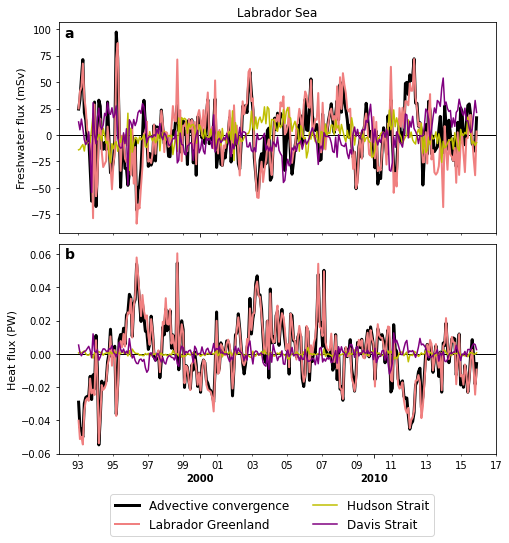

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e3, lw=3, color='k',
              label='Advective convergence')
axs[0].plot(flx_anom.time, flx_anom.sel(section='Labrador Greenland').fw*1e3, lw=2, color='lightcoral',
            label='Labrador Greenland')
axs[0].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').fw*1e3, lw=1.5, color='y',
            label='Hudson Strait')
axs[0].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').fw*1e3, lw=1.5, color='purple',
              label='Davis Strait')

axs[0].set_ylabel(r'Freshwater flux (mSv)',fontsize=11)
axs[0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0].transAxes)
axs[0].set_title(r'Labrador Sea', fontsize=12)

axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].plot(budgH_anom.time, budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-15, lw=3, color='k',
            label='Advective convergence')
axs[1].plot(flx_anom.time, flx_anom.sel(section='Labrador Greenland').heat,lw=2,color='lightcoral',
            label='Labrador Greenland')
axs[1].plot(flx_anom.time, -flx_anom.sel(section='Hudson Strait').heat, lw=1.5, color='y',
            label='Hudson Strait')
axs[1].plot(flx_anom.time, -flx_anom.sel(section='Davis Strait').heat, lw=1.5, color='purple',
            label='Davis Strait')
axs[1].set_ylabel(r'Heat flux (PW)', fontsize=11)
axs[1].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1].transAxes)
axs[1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.87, -0.16), ncol=2, fontsize=12)
format_xaxis(axs[1])

fig.subplots_adjust(left=0.17, right=0.93, bottom=0.2, top=0.95, hspace=0.05, wspace=0.12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

### Covariance ratio

In [14]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

#### LSEA Freshwater

#### LSEA Heat

In [30]:
df = pd.DataFrame({'time':budgH_anom.time,
                   'total':budgH_anom.sel(region='lsea',term='adv_ConvH')*1e-15,
                   'Labrador Greenland':flx_anom.sel(section='Labrador Greenland').heat,
                   'Hudson Strait':-flx_anom.sel(section='Hudson Strait').heat,
                   'Davis Strait':-flx_anom.sel(section='Davis Strait').heat})

In [31]:
df.set_index('time',inplace=True)
df['dt'] = ecco.reset_coords().dt.sel(time=slice('1993-01-01','2015-11-30')).to_dataframe().dt

In [32]:
# Annual
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [33]:
# Pentad
df_sub = df.loc[(df.index > '1994-12-31')&(df.index < '2015-01-01')]
df_5yr = df_sub.multiply(df_sub["dt"], axis="index").resample('5A',kind='period').mean().drop(columns=['dt'])

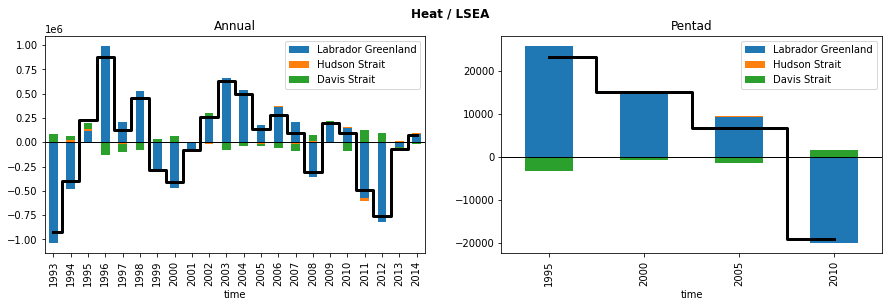

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

df_1yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[0])
axs[0].step(df_1yr.index.strftime('%Y'), df_1yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0].set_title('Annual')

df_5yr.drop(columns=['total']).plot.bar(stacked=True,ax=axs[1])
axs[1].step(df_5yr.index.strftime('%Y'), df_5yr.total, where='mid', c='k', lw=3, linestyle='-')
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1].set_title('Pentad')

#fig.suptitle('Freshwater / LSEA', fontweight='bold')
fig.suptitle('Heat / LSEA', fontweight='bold')

plt.show()

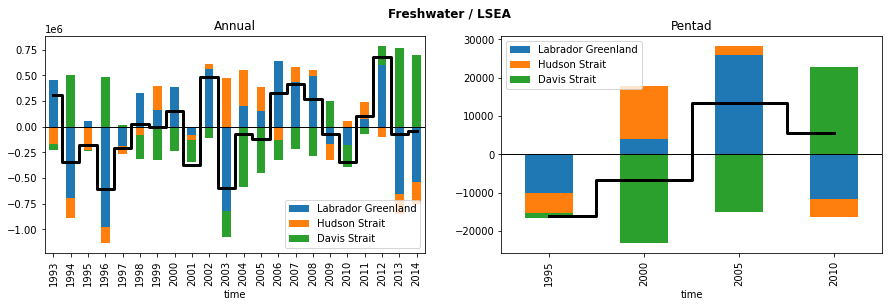

In [35]:
def cov_ratio(df):
    return pd.Series({term: df['total'].cov(df[term]) for term in df if term != 'total'})/np.var(df['total'],ddof=1)

In [36]:
corr1mo = cov_ratio(df.drop(columns=['dt'])).to_frame(name='monthly')
corr1yr = cov_ratio(df_1yr).to_frame(name='annual')
corr5yr = cov_ratio(df_5yr).to_frame(name='pentad')

#print('LSEA Freshwater')
#dfFw = corr1mo.join(corr1yr.join(corr5yr))
#print(dfFw)

print('LSEA Heat')
dfH = corr1mo.join(corr1yr.join(corr5yr))
print(dfH)

LSEA Heat
                     monthly    annual    pentad
Labrador Greenland  1.019476  1.114824  1.069419
Hudson Strait       0.001899 -0.000723 -0.002252
Davis Strait       -0.029095 -0.127210 -0.098991


LSEA Freshwater
                     monthly    annual    pentad
Labrador Greenland  0.938259  1.222508  0.840696
Hudson Strait       0.005331 -0.057919  0.005919
Davis Strait        0.046656 -0.166856  0.167848


In [23]:
dfFw.sort_values(by=['pentad'], ascending=False)

,monthly,annual,pentad
Labrador Greenland,0.938259,1.222508,0.840696
Davis Strait,0.046656,-0.166856,0.167848
Hudson Strait,0.005331,-0.057919,0.005919


In [24]:
dfFw.sum()

monthly    0.990245
annual     0.997733
pentad     1.014463
dtype: float64

In [37]:
#dfFw=dfFw.reindex(['Labrador Greenland','Davis Strait','Hudson Strait'])
dfH=dfH.reindex(['Labrador Greenland','Davis Strait','Hudson Strait'])

In [38]:
#dfFw.columns=pd.MultiIndex.from_tuples([('Freshwater','monthly'),('Freshwater','annual'),('Freshwater','pentad')])
dfH.columns=pd.MultiIndex.from_tuples([('Heat','monthly'),('Heat','annual'),('Heat','pentad')])

In [29]:
dfFw

Freshwater                    
                      monthly    annual    pentad
Labrador Greenland   0.938259  1.222508  0.840696
Davis Strait         0.046656 -0.166856  0.167848
Hudson Strait        0.005331 -0.057919  0.005919

In [39]:
dfH

Heat                    
                     monthly    annual    pentad
Labrador Greenland  1.019476  1.114824  1.069419
Davis Strait       -0.029095 -0.127210 -0.098991
Hudson Strait       0.001899 -0.000723 -0.002252

In [40]:
df_lsea = dfFw.join(dfH)

In [41]:
df_lsea

Freshwater                          Heat            \
                      monthly    annual    pentad   monthly    annual   
Labrador Greenland   0.938259  1.222508  0.840696  1.019476  1.114824   
Davis Strait         0.046656 -0.166856  0.167848 -0.029095 -0.127210   
Hudson Strait        0.005331 -0.057919  0.005919  0.001899 -0.000723   

                              
                      pentad  
Labrador Greenland  1.069419  
Davis Strait       -0.098991  
Hudson Strait      -0.002252

In [42]:
from openpyxl import Workbook

In [43]:
df_lsea.to_excel('/mnt/efs/table.xlsx')